# **Tutorial 3: In Silico Perturbation**

## **Step 1: Import libraries**

In [1]:
from SIDISH import SIDISH as sidish
import sys
import scanpy as sc
import pandas as pd
import numpy as np
import  torch
import random
import os
import matplotlib.pyplot as plt

/Users/admin/miniconda3/envs/sidish/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Set Seeds

In [2]:
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(1)
ite = 0
# Set seeds for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Call the seed setting function
set_seed(seed)

## **Step 2: Reload the saved data and SIDISH model**

### **2.1 Reload saved single-cell data**

In [3]:
path = "./LUNG/"
adata = sc.read_h5ad("{}adata_SIDISH.h5ad".format(path))

# Read survival+bulk dataset
bulk = pd.read_csv("../../DATA/processed_bulk.csv", index_col=0)

### **2.2 Reload trained SIDISH**

In [4]:
sdh = sidish(adata, bulk, "cpu", seed=ite)
sdh.init_Phase1(225, 20, 32, [512, 128], 512, "Adam", 1.0e-4, 1e-4, 0)
sdh.init_Phase2(500, 128, 1e-4, 0, 0.2, 256)
sdh.reload(path)

Reload Complete


### **2.3 Reload High-Risk cells threshold in final iteration of trained SIDISH**

In [5]:
sdh.get_percentille(0.90)

0.3678388405938091


0.3678388405938091

## **Step 3:Perform perturbation**

In [6]:
percentage_dict, pvalue_dict = sdh.run_Perturbation()

Calculating Stats: 100%|██████████| 1208/1208 [00:14<00:00, 80.73it/s]


Plot top 30 ranking genes, that is genes that when perturbed provokes a the most shift of High-Risk cells to Background. 

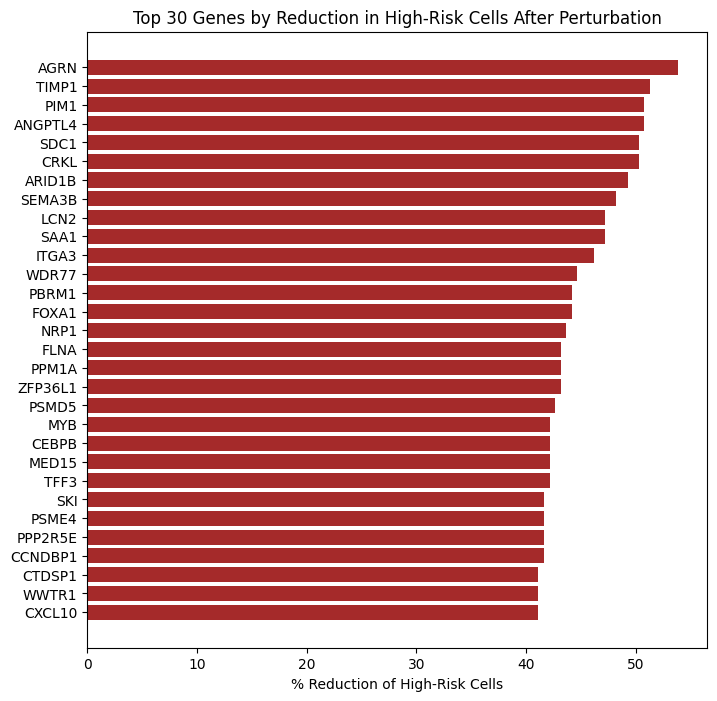

In [7]:
sdh.plot_top_perturbed_genes(percentage_dict, top_n=30)

Vizualisation of the effect of perturbing genes of intrest. 

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/admin/Documents/GitHub/SIDISH/SIDISH/SIDISH.py:427: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(self.adata, resolution=resolution, random_state=self.seed)


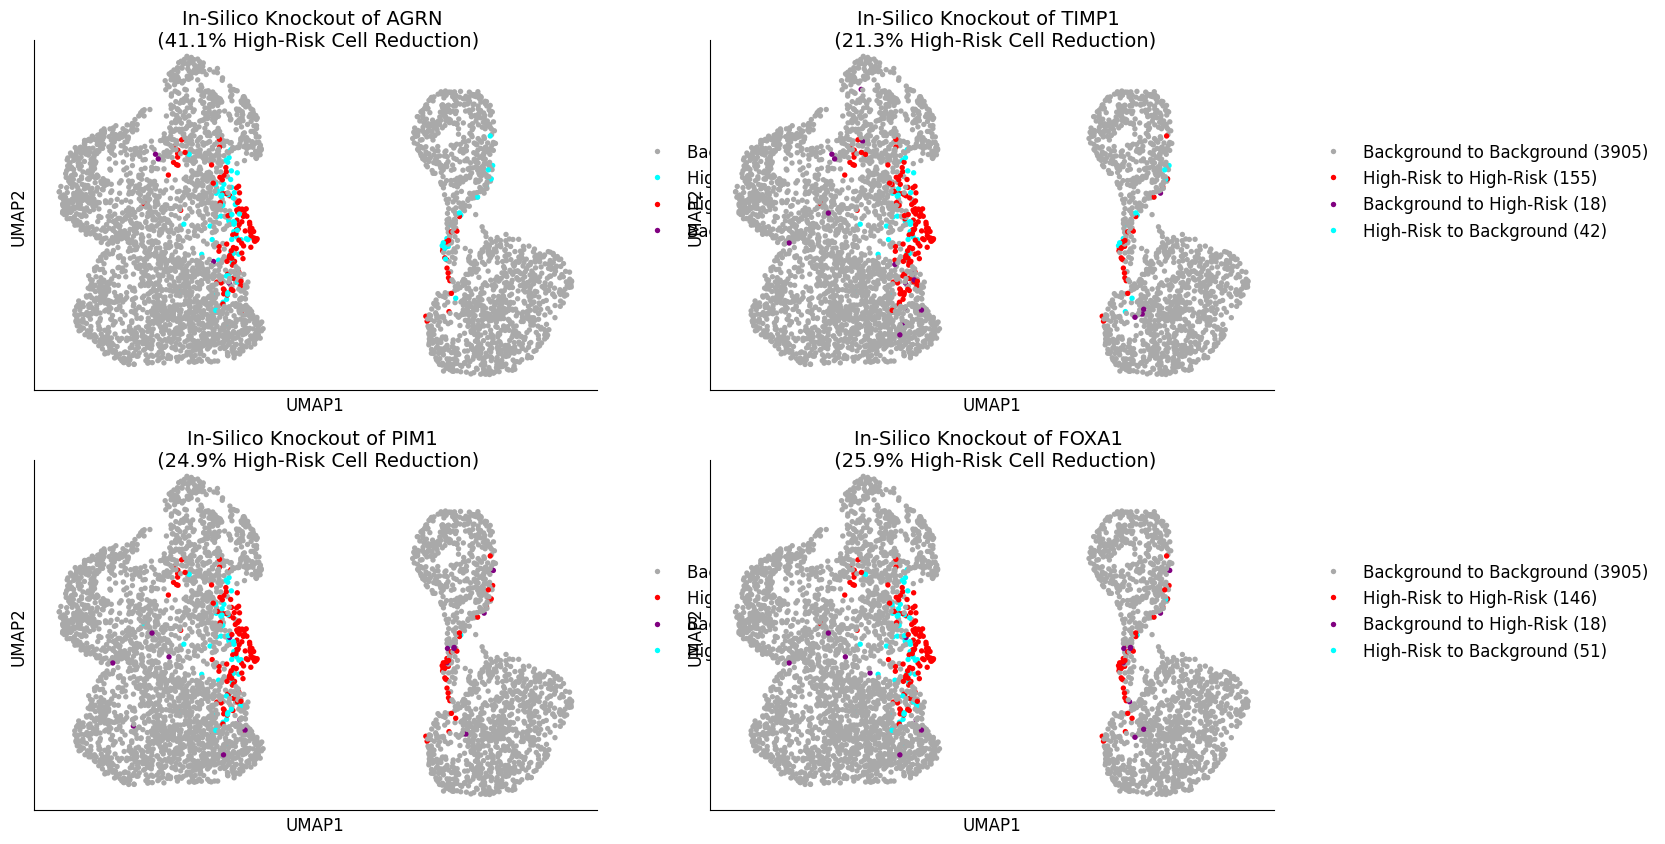

In [8]:
sdh.generate_umap_plots(['AGRN', 'TIMP1', "PIM1", 'FOXA1'], resolution=0.8, celltype=False)